In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import datetime
import matplotlib.pyplot as plt
appended_data = []
for page in range(1,19):
    xml = requests.get("http://api.worldbank.org/v2/indicator?per_page=1000&page={}".format(page)).content
    soup = BeautifulSoup(xml,"xml")
    for node in soup.find_all("wb:indicator"):
        id = node.attrs["id"]
        name = node.find("wb:name").text
        note = node.find("wb:sourceNote").text
        source = node.find("wb:source").text
        sourceID = node.find("wb:source").attrs["id"]
        df=  [sourceID,source,id,name,note]
        appended_data.append(df)
Source_info = pd.DataFrame(appended_data,columns=["SourceId","Source","IndicatorID","Indicator_Name","Note"])
ht = requests.get("https://www.nationsonline.org/oneworld/country_code_list.htm").content
soup1 = BeautifulSoup(ht)
table_html = soup1.find("table",{"id":"CountryCode"})
table = pd.read_html(str(table_html),header = 0, index_col = "A")
cc = pd.DataFrame(table[0])
cc =cc.drop(columns = 'Unnamed: 0')


In [2]:
def Search_Indicator(searchword):
    x= (Source_info[Source_info['Indicator_Name'].str.contains('{}'.format(searchword),case = False)])
    return x

def req_data(Indicator, Country_names = 'all' , start = 'all', end = 'all'):
    base_link = "http://api.worldbank.org/v2/"
    if Country_names == 'all':
        req_link = base_link + "country/all/"
    else:
        c=""
        for count in Country_names:
            Country = cc.loc[l,"A.2"]
            c = c + Country + ";"
        c = c[:-1]
        req_link = base_link + "country/{}/".format(c)
        
    if len(Indicator)>1:
        req_append = []
        Indi = ""
        for i in Indicator:
            source = (Source_info[Source_info['IndicatorID'].str.contains('{}'.format(i),case = False)])
            sid = str(int(source.SourceId))
            Indi = Indi + i + ";"
        Indi = Indi[:-1]
        req_link = req_link+ "indicator/{}".format(Indi) + "?source={}".format(sid)
        xml2 = requests.get(req_link).content
        soup2 = BeautifulSoup(xml2, "xml")
        for page in range(1,1+int(soup2.find("wb:data").attrs["pages"])):
            xml2 = requests.get( req_link+"&page={}".format(page)).content
            soup2 = BeautifulSoup(xml2, "xml")
            for node in soup2.find_all("wb:data")[1:]:
                country = node.find("wb:country").text
                ISO3 = node.find("wb:countryiso3code").text
                value = node.find("wb:value").text
                year = node.find("wb:date").text
                indicator = node.find("wb:indicator").attrs["id"]
                name = node.find("wb:indicator").text
                lst = [name,indicator,country,ISO3,year,value]
                req_append.append(lst)
    else:
        req_link = req_link + "indicator/" + str(Indicator[0])
        req_append = []
        xml2 = requests.get(req_link).content
        soup2 = BeautifulSoup(xml2, "xml")
        for page in range(1,1+int(soup2.find("wb:data").attrs["pages"])):
            xml2 = requests.get(req_link+"?page={}".format(page)).content
            soup2 = BeautifulSoup(xml2, "xml")
            for node in soup2.find_all("wb:data")[1:]:
                country = node.find("wb:country").text
                ISO3 = node.find("wb:countryiso3code").text
                value = node.find("wb:value").text
                year = node.find("wb:date").text
                indicator = node.find("wb:indicator").attrs["id"]
                name = node.find("wb:indicator").text
                lst = [name,indicator,country,ISO3,year,value]
                req_append.append(lst)
                
    req_dt = pd.DataFrame(req_append,columns=["Name","Indicator","Country","ISO3","Year","Value"])
    req_dt["Value"]= pd.to_numeric(req_dt["Value"])
    req_dt["Year"]= pd.to_datetime(req_dt["Year"],format = '%Y').dt.year
    return req_dt

In [3]:
req_dt = req_data(["PV.EST","VA.EST","GE.EST","RQ.EST","RL.EST","CC.EST"])

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas
link = "https://www.imf.org/external/pubs/ft/weo/2007/02/weodata/groups.htm"
html = requests.get(link).content
soup = BeautifulSoup(html)
ae = soup.find_all("table")
AE=[]
EM = []
for country in ae[3].find_all('p'):
    c = country.text.split('\r\n')
    AE = AE + c
for country in ae[9].find_all('p'):
    c = country.text.split('\r\n')
    EM = EM + c
EM = EM[:-2]
all_c = AE+EM
du = []
for i in all_c:
    if (i in AE):
        d = 1
    else:
        d = 0 
    du.append(d)
    
year = "2007" 
yr = [year for y in range(len(all_c))]
Y = pd.DataFrame({'Country': all_c,'Year':yr, 'Dummy_AE(1 if AE)':du})
Y.Country = Y.Country.str.replace('\d+', '')
html = requests.get("https://www.imf.org/external/pubs/ft/weo/2007/02/weodata/co.htm").content
i = BeautifulSoup(html)
tab= i.find("div",{"class":"fancy"}).find('table')
t = pd.read_html(str(tab),header = 0)
y = pd.DataFrame(t[0])[['ISO code','Country']]

AE = []
EM = []
for year in range(2008,2021):
    for period in ["01","02"]:    
        link = "https://www.imf.org/external/pubs/ft/weo/{}/{}/weodata/groups.htm".format(year,period)
        html = requests.get(link).content
        soup = BeautifulSoup(html)
        ae = soup.find_all("table")
        AE=[]
        EM = []
        if year == 2008:
            if period == "01":
                z = 3
                w = 9
            else:
                z = 4
                w = 10
        if year<=2013 :
            if year < 2009: 
                if period == "01":
                    cl = "fancy"
                else:
                    cl = "fancy tightest"
            else:
                cl = "fancy tightest"
            html1 = requests.get("https://www.imf.org/external/pubs/ft/weo/{}/{}/weodata/co.htm".format(year,period)).content
            i = BeautifulSoup(html1)
            tab= i.find("div",{"class":"{}".format(cl)}).find('table')
            t = pd.read_html(str(tab),header = 0)
            iso = pd.DataFrame(t[0])
            try:
                iso = iso[['ISO code','Country']]
            except:
                iso = iso[['ISO Code','Country']]
                iso = iso.rename(columns = {'ISO Code':'ISO code'})    
            y = y.append(iso)

        if year>=2013:
            z=4
            w=9
        for country in ae[z].find_all('p'):
            c = country.text.split('\r\n')
            AE = AE + c
        for country in ae[w].find_all('p'):
            c = country.text.split('\r\n')
            EM = EM + c
        EM = EM[:-2]
        all_c = AE+EM
        du = []
        for i in all_c:
            if i in AE:
                d = 1
            else:
                d = 0 
            du.append(d)

        yr = [year for po in range(len(all_c))]
        dt = pd.DataFrame({'Country': all_c,'Year':yr, 'Dummy_AE(1 if AE)':du})
        dt.Country = dt.Country.str.replace('\d+','')
        frames =[Y,dt]
        Y = pd.concat(frames)
        Y = Y[Y['Country'].astype(bool)]
        y = y.drop_duplicates(subset = ['Country'])

df_right = Y.merge(y[["ISO code","Country"]],how = "left",on = "Country")
final_df = pd.merge(req_dt,df_right[["ISO code","Year","Dummy_AE(1 if AE)"]],how="left",left_on =["ISO3","Year"],right_on = ["ISO code","Year"])
final_df.to_csv("GI_AE_Datafile.csv",na_rep = 2)

NameError: name 'groups' is not defined

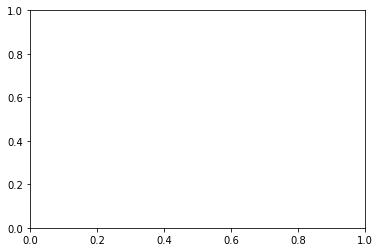

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.ISO3, group.Value, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [6]:
final_df

,Name,Indicator,Country,ISO3,Year,Value,ISO code,Dummy_AE(1 if AE)
0,Political Stability and Absence of Violence/Te...,PV.EST,Afghanistan,AFG,2019,-2.649407,AFG,0.0
1,Political Stability and Absence of Violence/Te...,PV.EST,Afghanistan,AFG,2019,-2.649407,AFG,0.0
2,Political Stability and Absence of Violence/Te...,PV.EST,Afghanistan,AFG,2018,-2.751611,AFG,0.0
3,Political Stability and Absence of Violence/Te...,PV.EST,Afghanistan,AFG,2018,-2.751611,AFG,0.0
4,Political Stability and Absence of Violence/Te...,PV.EST,Afghanistan,AFG,2017,-2.800609,AFG,0.0
...,...,...,...,...,...,...,...,...
39925,Control of Corruption: Estimate,CC.EST,Zimbabwe,ZWE,2003,-1.245055,NaN,NaN
39926,Control of Corruption: Estimate,CC.EST,Zimbabwe,ZWE,2002,-1.228440,NaN,NaN
39927,Control of Corruption: Estimate,CC.EST,Zimbabwe,ZWE,2000,-0.982141,NaN,NaN
39928,Control of Corruption: Estimate,CC.EST,Zimbabwe,ZWE,1998,-0.480248,NaN,NaN


In [7]:
final_df.to_csv("GI_AE_Datafile.csv",na_rep = 2)